<a href="https://colab.research.google.com/github/VitorFRodrigues/PUCMinas_DataScience/blob/main/03-Tec_Amostragem_Mod_regressao/Exercicios/TrabalhoFinal/TrabalhoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Realizar um projeto utilizando um dos modelos apresentados na disciplina.

1 ) Acessar o https://www.kaggle.com/

2) Selecionar a base de escolha e que se adeque ao modelo.

3) Contextualizar o problema a ser resolvido.

4) processamento de dados

5) Analise de variáveis - análise descritiva

6) análise de correlação

7) validação de pressupostos

8) rodar o modelo

9) interpretação da saída (métricas de avaliação e coeficientes)

Entregar o notebook (em python ou r com as saídas comentadas com a sua interpretação) + a base de dados utilizada.

# Grupo 02

Instituição: Pontifícia Universidade Católica de Minas Gerais

Alunos:

* Alessandro Augusto Bezerra
* Robson Gomes de Lima
* Tiago Henrique Lacerda
* Vitor Fernando de Souza Rodrigues

Disciplina: Técnicas de Amostragem e Modelos de Regressão

Docente: Anaíle Mendes Rabelo

# 1. Introdução

FAZER UMA INTRODUÇÃO.

# 2. Importação de bibliotecas

In [1]:
# Importação de bibliotecas usadas neste notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import lilliefors
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# 3. Coleta de dados dos arquivos

O conjunto de dados foi baixado a partir do [kaggle](https://www.kaggle.com/datasets/dantebarros/transformed-data-from-quinto-andars-platform). Para retirar a necessidade de download, o *dataset* foi upado para um site no github onde os dados crus ("raw") podem ser encontrados.

Este arquivo (**quinto andar transformed data**) representam dados que contém informações detalhadas sobre apartamentos e casas para aluguel no site do quinto andar.

In [23]:
url = 'https://media.githubusercontent.com/media/VitorFRodrigues/PUCMinas_DataScience/main/03-Tec_Amostragem_Mod_regressao/Exercicios/TrabalhoFinal/quinto_andar_transformed_data.csv'
dados = pd.read_csv(url)
dados.head()

,url,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
0,https://www.quintoandar.com.br/imovel/89332996...,Liberdade,1900.0,424.0,5.0,25.0,38.0,2392.0,57.0,1.0,1.0,1.0,18.0,1.0,0.0,1.0
1,https://www.quintoandar.com.br/imovel/89334069...,Santa Cecília,1190.0,460.0,0.0,16.0,23.0,1689.0,56.0,1.0,1.0,0.0,11.0,1.0,1.0,1.0
2,https://www.quintoandar.com.br/imovel/89333859...,Aclimação,2330.0,450.0,5.0,30.0,46.0,2861.0,48.0,1.0,1.0,1.0,10.0,1.0,0.0,1.0
3,https://www.quintoandar.com.br/imovel/89337065...,Liberdade,1850.0,418.0,6.0,24.0,37.0,2335.0,44.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
4,https://www.quintoandar.com.br/imovel/89337700...,Vila Guilherme,2200.0,392.0,10.0,28.0,44.0,2674.0,62.0,2.0,2.0,1.0,8.0,1.0,0.0,0.0


Abaixo estão descritas as colunas deste dataframe. Vale salientar que os dados compilados aqui foram retirados do [site](https://www.quintoandar.com.br/) em 2019, sendo assim, os dados estão desatualizados. De todo modo, o método de elaboração do modelo de regressão treinado neste notebook permanece, podendo o mesmo ser retreinado com dados mais atuais.

* `url`: Endereço eletrônico do imóvel.
* `bairro`: Bairro em que o imóvel se encontra.
* `aluguel`: Valor do aluguel.
* `condominio`: Valor do condomínio.
* `iptu`: Valor do iptu.
* `seguro_incendio`: custo do seguro para incêndio.
* `taxa_serviço`: taxa de serviço.
* `total`: Soma de valores a contar de `aluguel` até `taxa_servico`.
* `metragem`: área do imóvel em metros quadrados.
* `quarto`: quantidade de quartos.
* `banheiro`: quantidade de banheiros.
* `vaga_carro`: quantidade de vagas para carro.
* `andar`: andar em que o imóvel se encontra.
* `aceita_pet`: se o imóvel aceita pets, sendo `1.0` = 'Sim' e `0.0` = 'Não'.
* `mobilia`: se o imóvel possui mobilia, sendo `1.0` = 'Sim' e `0.0` = 'Não'.
* `metro_prox`: se há metrô nas proximidades, sendo `1.0` = 'Sim' e `0.0` = 'Não'.

In [3]:
print(f'Número total de linhas e colunas do dataset Quinto Andar: {dados.shape}')

Número total de linhas e colunas do dataset Quinto Andar: (2775, 16)


# 4. Análise do conjunto de dados

Inicialmente, vamos realizar uma análise rápida no dataframe, buscando entender os tipos de dados compostos em cada coluna e a existência de valores nulos.

Vamos realizar uma análise rápida a respeito das colunas do dataframe com o intuito de identificar os pontos de trabalho e limpeza a ser realizado mais a frente.

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              2775 non-null   object 
 1   bairro           2775 non-null   object 
 2   aluguel          2775 non-null   float64
 3   condominio       2768 non-null   float64
 4   iptu             2767 non-null   float64
 5   seguro_incendio  2775 non-null   float64
 6   taxa_serviço     2775 non-null   float64
 7   total            2775 non-null   float64
 8   metragem         2775 non-null   float64
 9   quarto           2775 non-null   float64
 10  banheiro         2775 non-null   float64
 11  vaga_carro       2775 non-null   float64
 12  andar            2775 non-null   float64
 13  aceita_pet       2775 non-null   float64
 14  mobilia          2775 non-null   float64
 15  metro_prox       2775 non-null   float64
dtypes: float64(14), object(2)
memory usage: 347.0+ KB


Vemos que temos 2.775 linhas com valores em cada coluna, a exceção das colunas `condominio` e `iptu` que possuem valores nulos. Além disso, todas as colunas são do tipo float exceto `url` e `bairro` visto que este são tipo string.

In [5]:
dados_com_linhas_nulas = dados[dados.isnull().any(axis=1)]
dados_com_linhas_nulas

,url,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
321,https://www.quintoandar.com.br/imovel/89278332...,Jardim Paulista,3530.0,1000.0,NaN,45.0,70.0,4723.0,75.0,1.0,2.0,1.0,10.0,1.0,0.0,1.0
580,https://www.quintoandar.com.br/imovel/89276781...,Aclimação,1500.0,477.0,NaN,20.0,30.0,2027.0,67.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0
732,https://www.quintoandar.com.br/imovel/89277791...,Vila Olímpia,3700.0,0.0,NaN,47.0,74.0,3821.0,60.0,1.0,1.0,1.0,15.0,0.0,0.0,0.0
987,https://www.quintoandar.com.br/imovel/89288689...,Bela Vista,2960.0,NaN,125.0,49.0,59.0,3193.0,100.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0
1348,https://www.quintoandar.com.br/imovel/89277231...,Consolação,2696.0,1033.0,NaN,35.0,53.0,3882.0,88.0,3.0,2.0,1.0,4.0,1.0,1.0,1.0
1391,https://www.quintoandar.com.br/imovel/89310205...,Perdizes,5200.0,NaN,1030.0,86.0,104.0,6420.0,220.0,3.0,3.0,1.0,0.0,1.0,0.0,0.0
1486,https://www.quintoandar.com.br/imovel/89279154...,Jardim Paulista,6750.0,1400.0,NaN,86.0,135.0,8371.0,90.0,1.0,2.0,2.0,4.0,0.0,1.0,1.0
1527,https://www.quintoandar.com.br/imovel/89310896...,Aclimação,3000.0,NaN,158.0,50.0,60.0,3268.0,90.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0
1709,https://www.quintoandar.com.br/imovel/89281155...,Aclimação,3000.0,1100.0,NaN,39.0,60.0,4199.0,100.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0
1801,https://www.quintoandar.com.br/imovel/89284189...,Ipiranga,2600.0,NaN,100.0,43.0,52.0,2795.0,100.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0


In [6]:
percent = dados_com_linhas_nulas.shape[0]/dados.shape[0]
print(f'A quantidade de linhas com valores nulos representam {percent*100:.2f}% do total. \nSendo assim excluiremos estas linhas')

A quantidade de linhas com valores nulos representam 0.54% do total. 
Sendo assim excluiremos estas linhas


In [7]:
dados.dropna(inplace=True)

In [8]:
dados.describe()

,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
count,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000
mean,2275.859783,597.582246,283.667754,29.893478,45.314493,3233.472464,63.691304,1.593116,1.398188,0.627536,5.939130,0.776087,0.202536,0.733696
std,1327.682018,429.929323,9436.591175,17.637881,26.582778,9612.624659,38.590559,0.748581,0.686796,0.674473,4.999013,0.416940,0.401962,0.442105
min,500.000000,0.000000,0.000000,7.000000,10.000000,697.000000,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1400.000000,330.000000,0.000000,18.000000,28.000000,1877.500000,40.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000
50%,1950.000000,520.000000,54.000000,26.000000,39.000000,2613.500000,52.000000,1.000000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000
75%,2730.000000,800.000000,140.000000,36.000000,54.000000,3752.250000,75.250000,2.000000,2.000000,1.000000,9.000000,1.000000,0.000000,1.000000
max,11250.000000,3300.000000,495800.000000,187.000000,225.000000,499600.000000,587.000000,5.000000,7.000000,6.000000,43.000000,1.000000,1.000000,1.000000


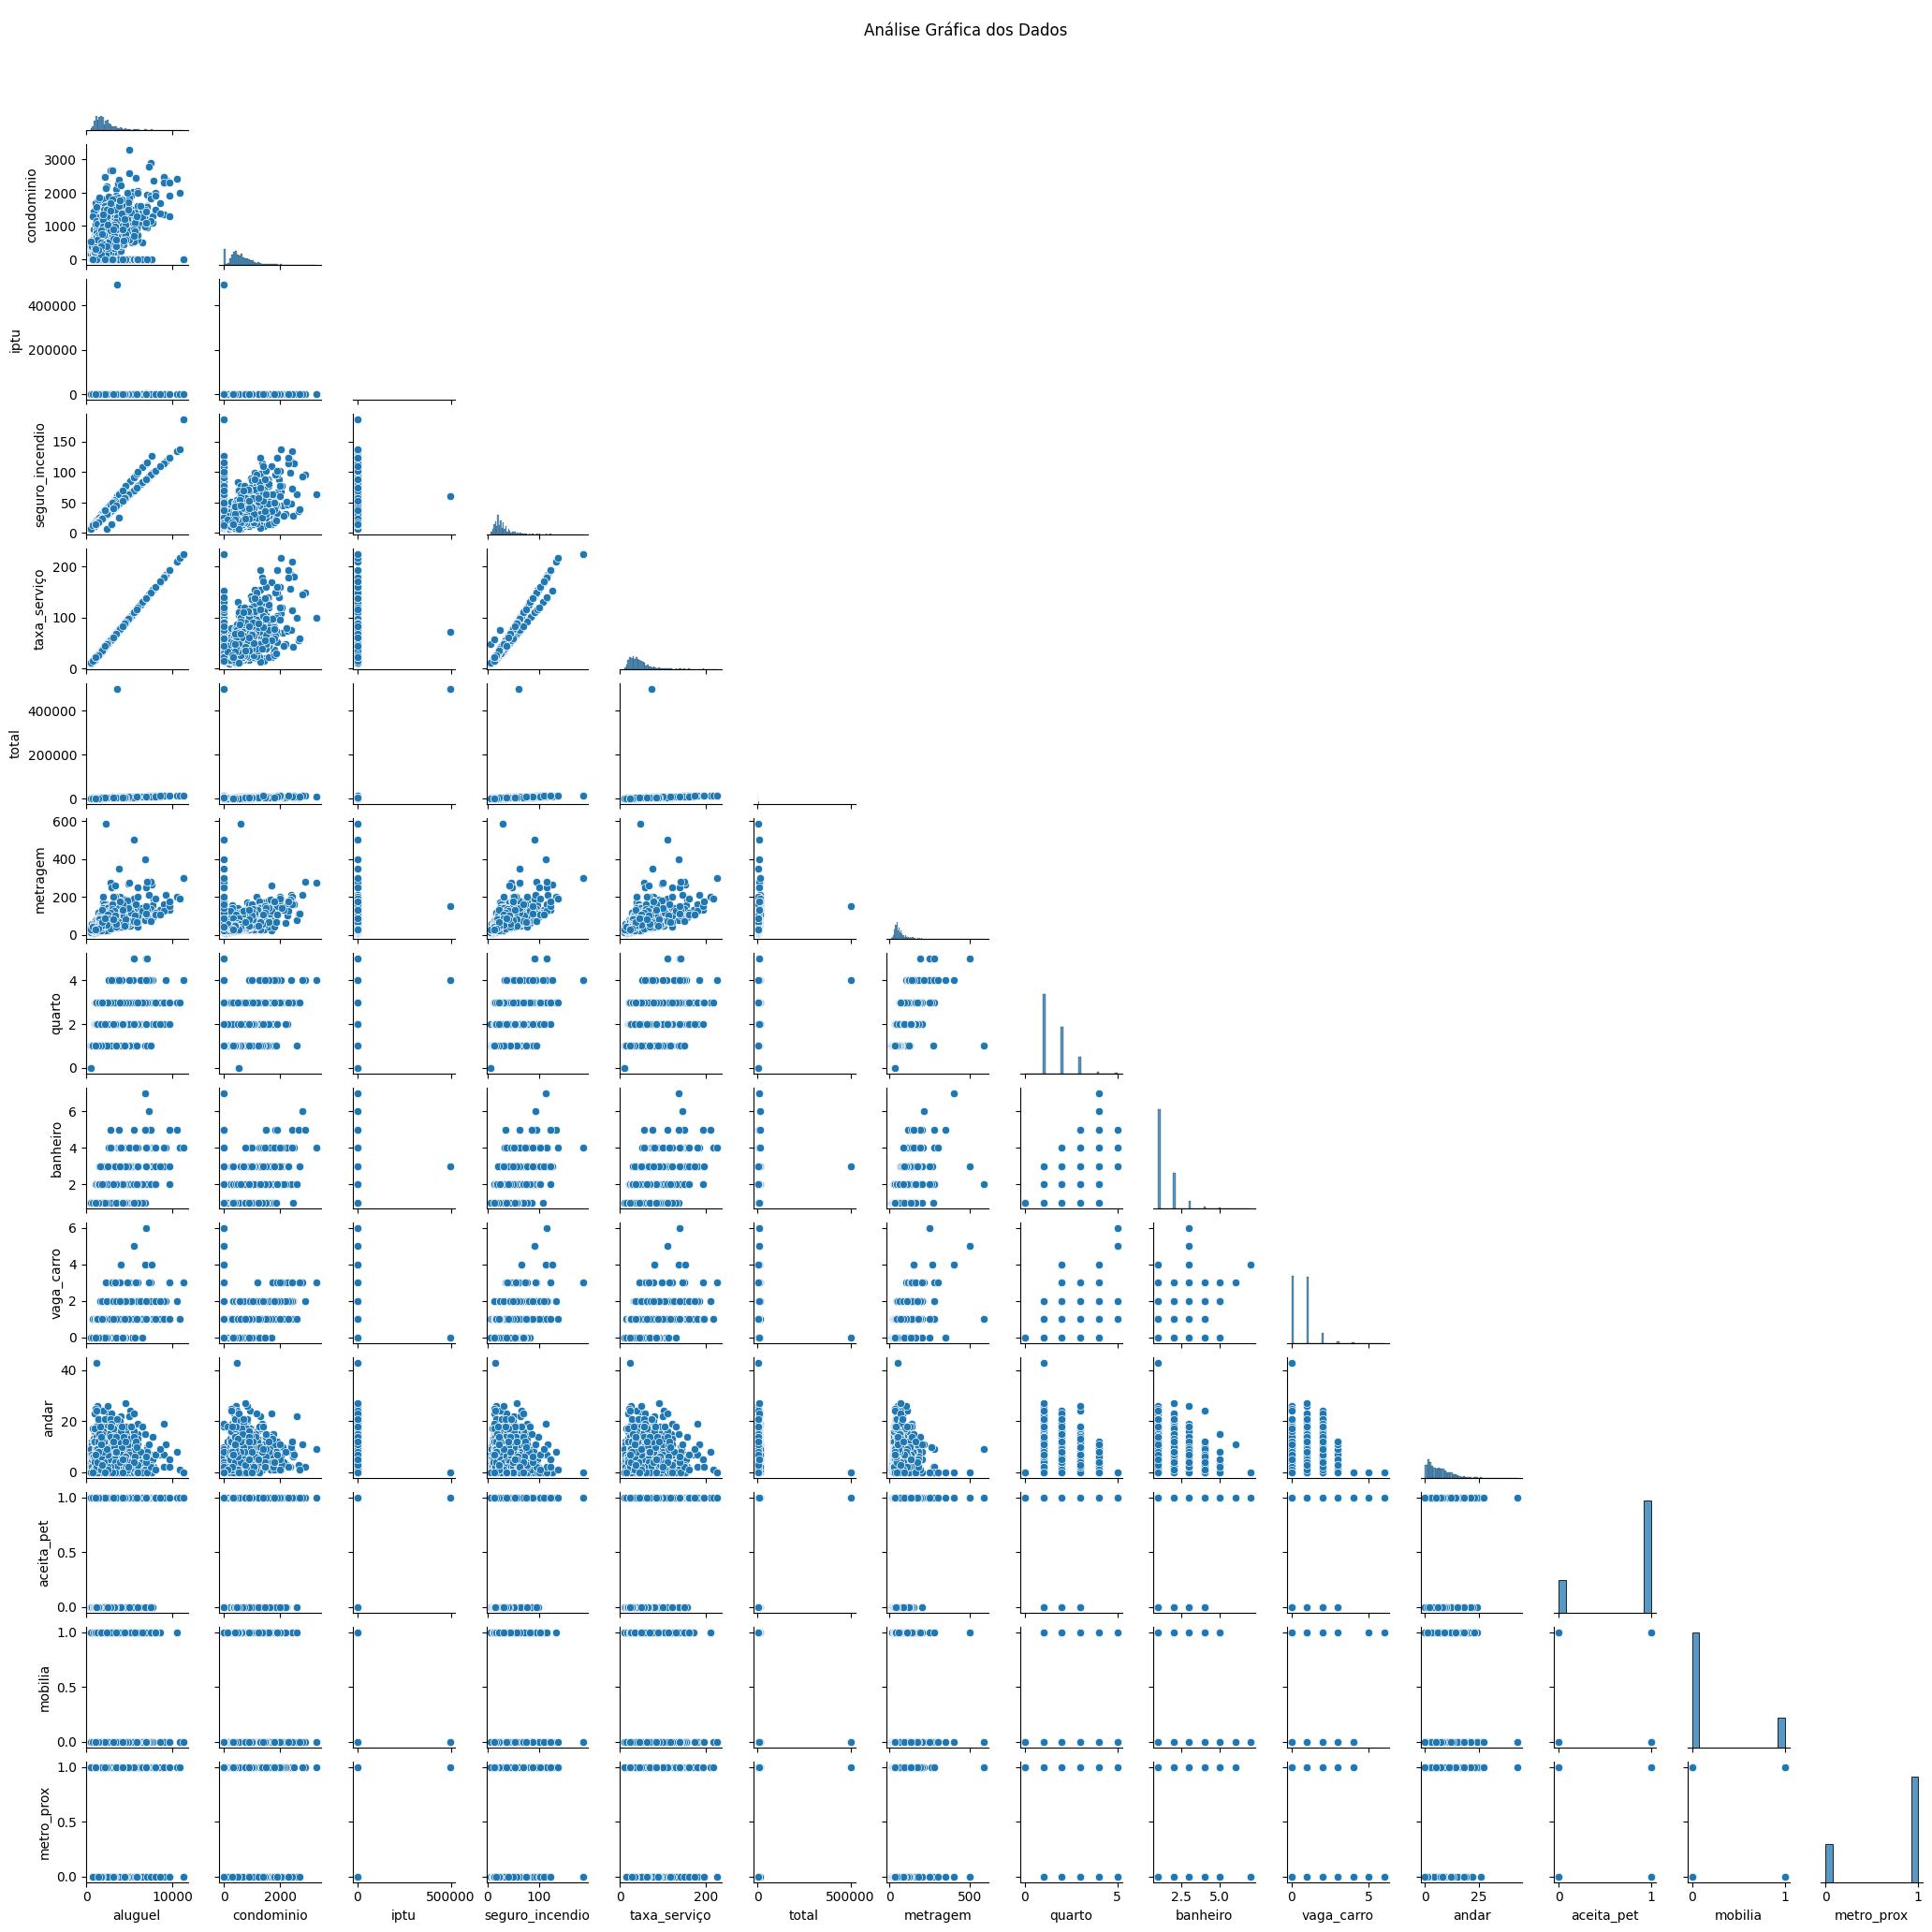

In [9]:
# Análise gráfica - Pairplot
sns.pairplot(dados, corner=True, height=1.5)
plt.suptitle("Análise Gráfica dos Dados")
plt.show()

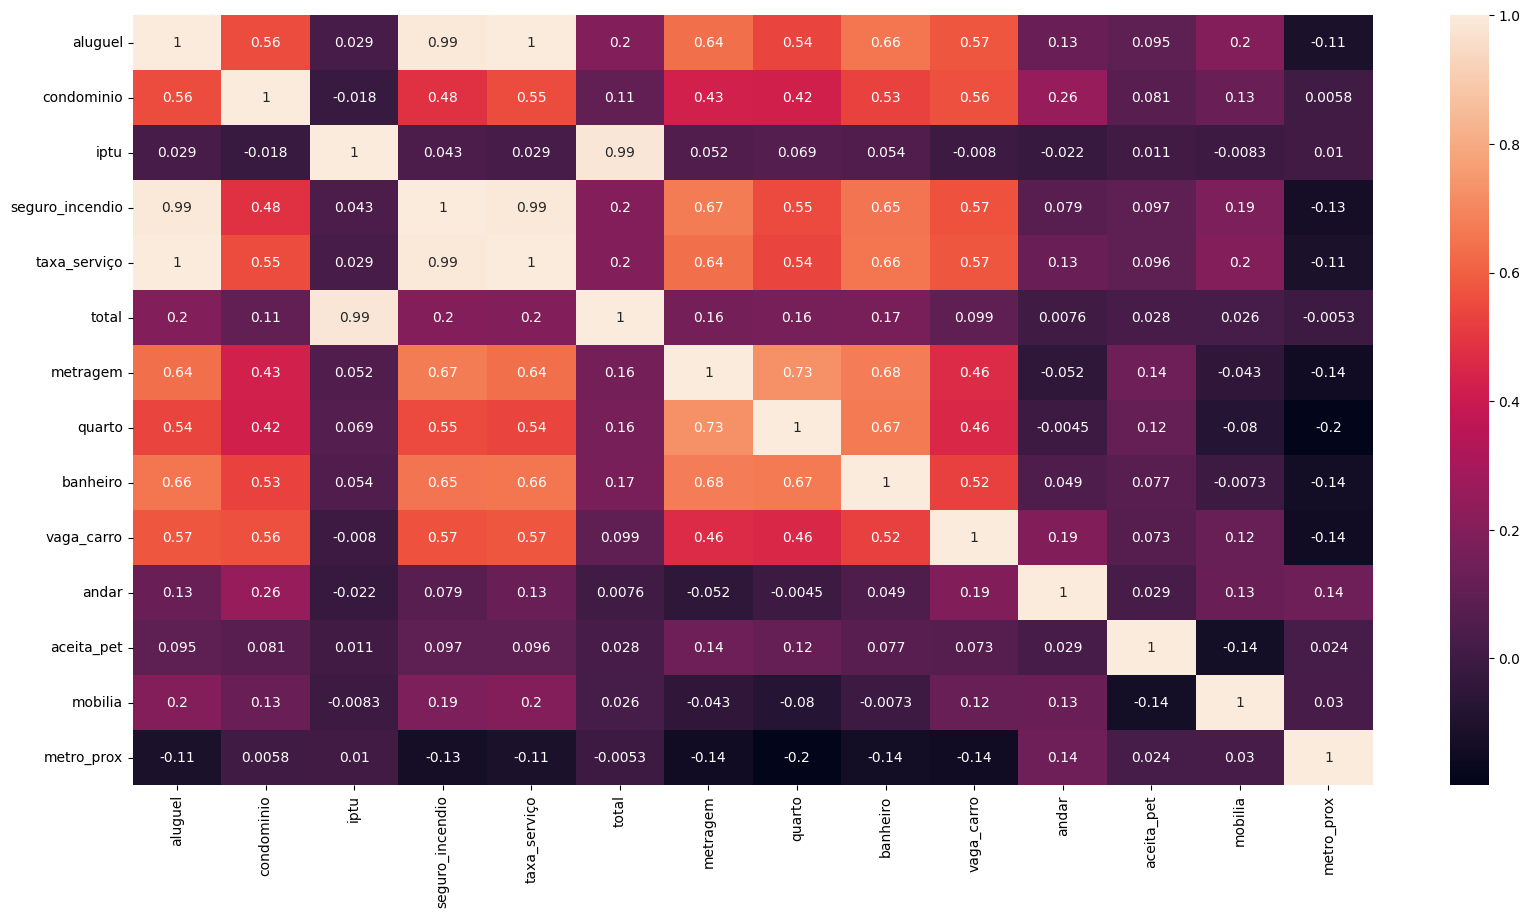

In [10]:
# Mapa de correlação
plt.figure(figsize=(20,10))
corr = dados[dados.describe().columns].corr()
sns.heatmap(corr, annot=True)
plt.show()

In [11]:
filtro_correlacao_max = 0.7
filtro_correlacao_min = 0.3
lista_selecionada_1 = corr['aluguel'][(corr['aluguel'].abs() > filtro_correlacao_min) & (corr['aluguel'].abs() < filtro_correlacao_max)].sort_values(ascending=False).index.to_list()[1:]
lista_selecionada_1

['metragem', 'vaga_carro', 'condominio', 'quarto']

In [12]:
filtro_correlacao_max = 1
filtro_correlacao_min = 0.3
lista_selecionada_2 = corr['aluguel'][(corr['aluguel'].abs() > filtro_correlacao_min) & (corr['aluguel'].abs() < filtro_correlacao_max)].sort_values(ascending=False).index.to_list()[1:]
lista_selecionada_2

['seguro_incendio',
 'banheiro',
 'metragem',
 'vaga_carro',
 'condominio',
 'quarto']

# 5. Criação do modelo

In [13]:
# Definindo a variável dependente e independentes
X_1 = dados[lista_selecionada_1]  # Variável independente
X_2 = dados[lista_selecionada_2]  # Variável independente
y = dados['aluguel']  # Variável dependente

# Adicionando uma constante à variável independente
X_1 = sm.add_constant(X_1)
X_2 = sm.add_constant(X_2)

# Ajustando o modelo de regressão linear
modelo_1 = sm.OLS(y, X_1).fit()
modelo_2 = sm.OLS(y, X_2).fit()

# Sumário do modelo
modelo_summary_1 = modelo_1.summary()
modelo_summary_2 = modelo_2.summary()

# sm.OLS() é usado para ajustar o modelo de regressão linear ordinária.
# sm.add_constant() é necessário pois o OLS não adiciona automaticamente a constante (intercepto).

# 6. Análise dos pressupostos e validação do modelo

## 6.1. Teste de Homocedasticidade com Breusch-Pagan

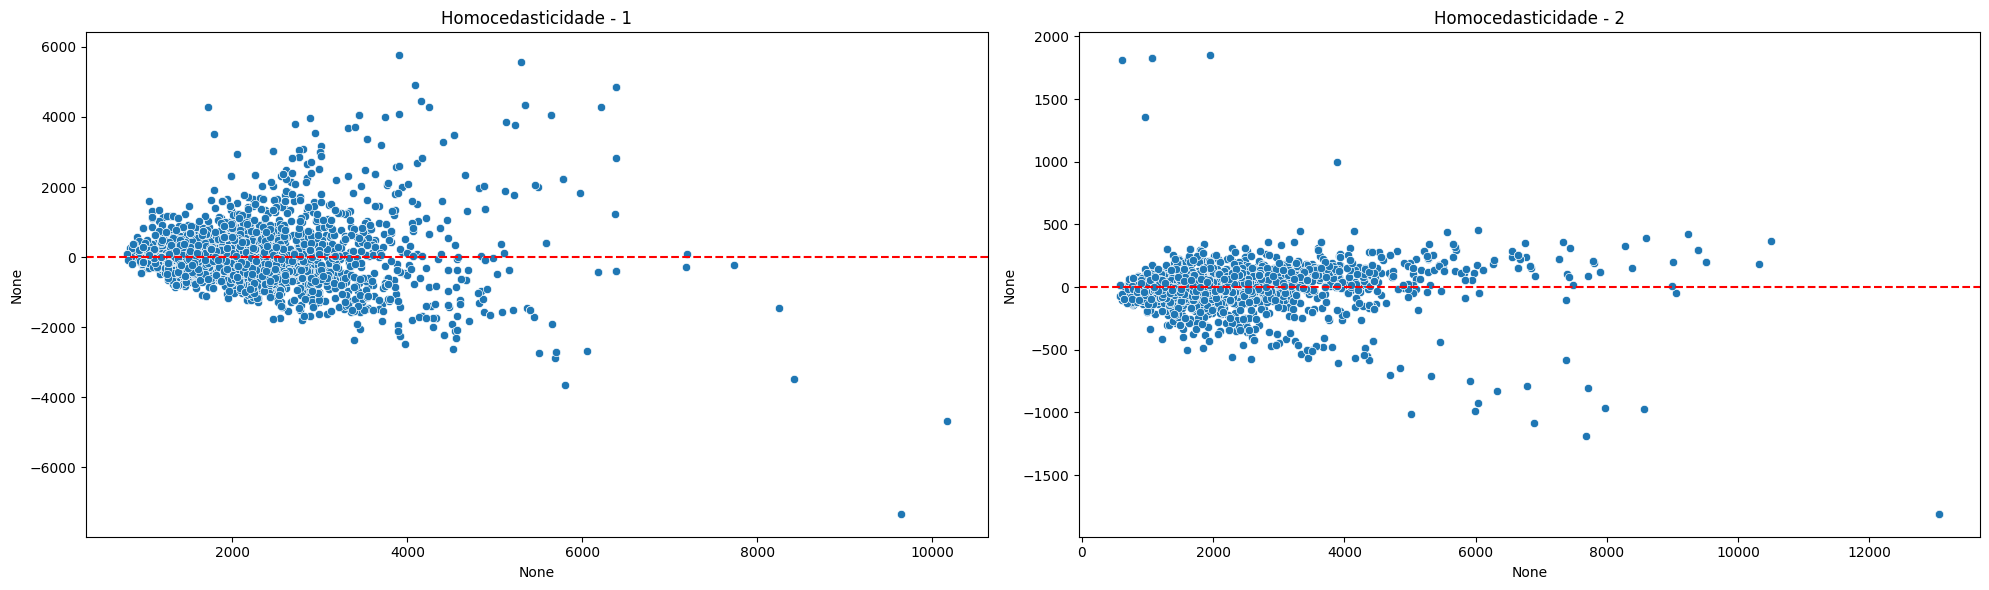

In [14]:
# Resíduos dos modelos
residuos_1 = modelo_1.resid
residuos_2 = modelo_2.resid

# Gráfico de homocedasticidade
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=modelo_1.fittedvalues, y=residuos_1)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Homocedasticidade - 1')

plt.subplot(1, 2, 2)
sns.scatterplot(x=modelo_2.fittedvalues, y=residuos_2)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Homocedasticidade - 2')

plt.tight_layout()
plt.show()

In [15]:
# Calcula os resíduos do modelo
# Criação de uma lista de tuplas com os modelos e seus respectivos nomes
modelos = [
    ("modelo_1", modelo_1, dados[lista_selecionada_1]),
    ("modelo_2", modelo_2, dados[lista_selecionada_2]),
]

for nome, modelo, col in modelos:
    estatistica, p, f, fp = het_breuschpagan(modelo.resid, modelo.model.exog)
    print(f'Estatísticas de teste para {nome}: {estatistica:.2e}')
    print(f'p-valor: {p:.2e}')
    print(f'f-valor: {fp:.2e}')
    print(f'f_p-valor: {f:.2e}\n')

Estatísticas de teste para modelo_1: 7.08e+02
p-valor: 6.33e-152
f-valor: 1.62e-175
f_p-valor: 2.38e+02

Estatísticas de teste para modelo_2: 3.92e+02
p-valor: 1.86e-81
f-valor: 6.76e-88
f_p-valor: 7.58e+01



## 6.2. Breusch-Pagan

Se o p-valor do teste menor que 0.05, indica a presença de heterocedasticidade e pode ser necessário ajustar o modelo ou usar métodos robustos para estimativa de variância.

| Modelo   | P-Valor |
|----------|:-------:|
| modelo_1 | < 0.05  |
| modelo_2 | < 0.05  |


## 6.3. Teste de Normalidade dos Resíduos com Shapiro-Wilk

In [16]:
for nome, modelo, col in modelos:
    estatistica_shapiro,p_shapiro = stats.shapiro(modelo.resid)
    print(f'Estatísticas de teste {nome}: {estatistica_shapiro:.2e}')
    print(f'p-valor: {p_shapiro:.2e}\n')

Estatísticas de teste modelo_1: 8.88e-01
p-valor: 6.86e-41

Estatísticas de teste modelo_2: 7.57e-01
p-valor: 0.00e+00



## 6.4. Shapiro

Se p-valor do shapiro é superior a 0.05,isso indica que os resíduos seguem aproximadamente uma distribuição normal.

| Modelo   | P-Valor |
|----------|:-------:|
| modelo_1 | < 0.05  |
| modelo_2 | < 0.05  |


## 6.5. Análise de normalidade QQ-plot

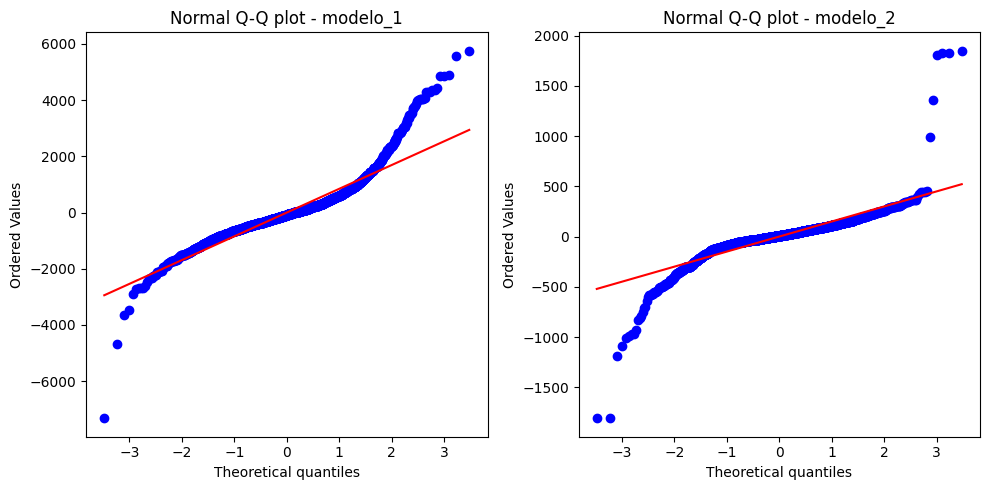

In [17]:
num_modelos = len(modelos)
fig, axes = plt.subplots(1, num_modelos, figsize=(5 * num_modelos, 5))

for ax, (nome, modelo, col) in zip(axes, modelos):
    stats.probplot(modelo.resid,dist="norm", plot=ax)
    ax.set_title(f"Normal Q-Q plot - {nome}")
plt.tight_layout()
plt.show()

## 6.6. Análise de resíduos Padronizados

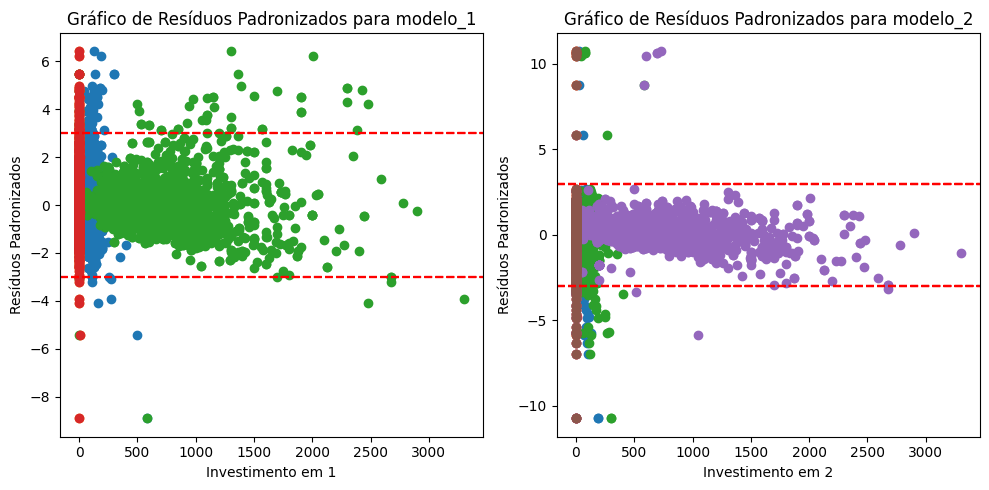

In [18]:
num_modelos = len(modelos)

fig, axes = plt.subplots(1, num_modelos, figsize=(5 * num_modelos, 5))

for ax, (nome, modelo, col) in zip(axes, modelos):
    residuos_padronizados = modelo.get_influence().resid_studentized_internal

    # Cria um gráfico de resíduos
    if isinstance(col, pd.Series):
        ax.scatter(col, residuos_padronizados)
        ax.axhline(y=3, color='r', linestyle='--')
        ax.axhline(y=-3, color='r', linestyle='--')
        ax.set_title(f'Gráfico de Resíduos Padronizados para {nome}')
        ax.set_xlabel('Investimento em ' + nome.split("_")[1].capitalize())
        ax.set_ylabel('Resíduos Padronizados')
    else:
        for i in col.columns:
            ax.scatter(col[i], residuos_padronizados)
            ax.axhline(y=3, color='r', linestyle='--')
            ax.axhline(y=-3, color='r', linestyle='--')
            ax.set_title(f'Gráfico de Resíduos Padronizados para {nome}')
            ax.set_xlabel('Investimento em ' + nome.split("_")[1].capitalize())
            ax.set_ylabel('Resíduos Padronizados')

plt.tight_layout()
plt.show()

## 6.7. Análise geral dos residuos

# 7. Analise do modelo

## 7.1. Análise de Multicolinearidade

In [19]:
vifs = [
    add_constant(dados[lista_selecionada_1]),
    add_constant(dados[lista_selecionada_2])
]

for vif in vifs:
    print(pd.Series([variance_inflation_factor(vif.values, j) for j in range(vif.shape[1])], index=vif.columns))
    print()

const         5.948216
metragem      2.254426
vaga_carro    1.634365
condominio    1.557562
quarto        2.235372
dtype: float64

const              6.749534
seguro_incendio    2.344723
banheiro           2.561748
metragem           2.866632
vaga_carro         1.804433
condominio         1.663092
quarto             2.448807
dtype: float64



O output será um DataFrame que mostra o VIF para cada variável no conjunto de dados, incluindo a constante. Se o VIF for maior que 10 (ou, em alguns contextos, maior que 5), isso indica que há multicolinearidade significativa.

Neste exemplo, não há altos valores de VIF, indicando que não há a presença de multicolinearidade entre essas variáveis.

In [20]:
for nome, modelo, dados in modelos:
    print(str(modelo.summary()))

                            OLS Regression Results                            
Dep. Variable:                aluguel   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     819.6
Date:                Sat, 13 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:28:50   Log-Likelihood:                -22682.
No. Observations:                2760   AIC:                         4.537e+04
Df Residuals:                    2755   BIC:                         4.540e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        567.9747     41.680     13.627      0.0

| Modelo  | Teste T (Significância dos Coeficientes) | Teste F (Significância Global) | R² Ajustado |
|---------|-----------------------------------------|--------------------------------|-------------|
| TV      | ✅                                        | ✅                              | 0.610       |
| Rádio   | ✅                                        | ✅                              | 0.329       |
| Jornal  | ✅                                        | ✅                              | 0.047       |
| Total   | ❌(Jornal)                                | ❌(Jornal)                      | 0.896       |

**Teste T:**
O Teste T avalia a significância estatística de cada coeficiente no modelo. Um p-valor baixo (< 0.05) indica que o coeficiente é significativo. Nos resultados fornecidos, todos os modelos mostraram coeficientes significativos (p-valor < 0.05 para os coeficientes de TV, Rádio e Jornal).

**Teste F:**
O Teste F avalia a significância global do modelo. Um p-valor baixo (< 0.05) sugere que o modelo, como um todo, é significativo. Todos os modelos (TV, Rádio e Jornal) apresentaram p-valores baixos no Teste F, indicando que são estatisticamente significativos.

**R² Ajustado:**
O R² Ajustado reflete a porcentagem da variabilidade da variável dependente explicada pelo modelo, ajustada pelo número de preditores. Valores mais altos indicam um melhor ajuste. No caso, o modelo de TV tem um R² Ajustado de 0.610, indicando que cerca de 61% da variabilidade em Vendas é explicada pelo modelo. Os modelos de Rádio e Jornal têm R² Ajustado mais baixos, indicando um ajuste menos eficaz.

## 7.2. Gráfico dos modelos ajustados

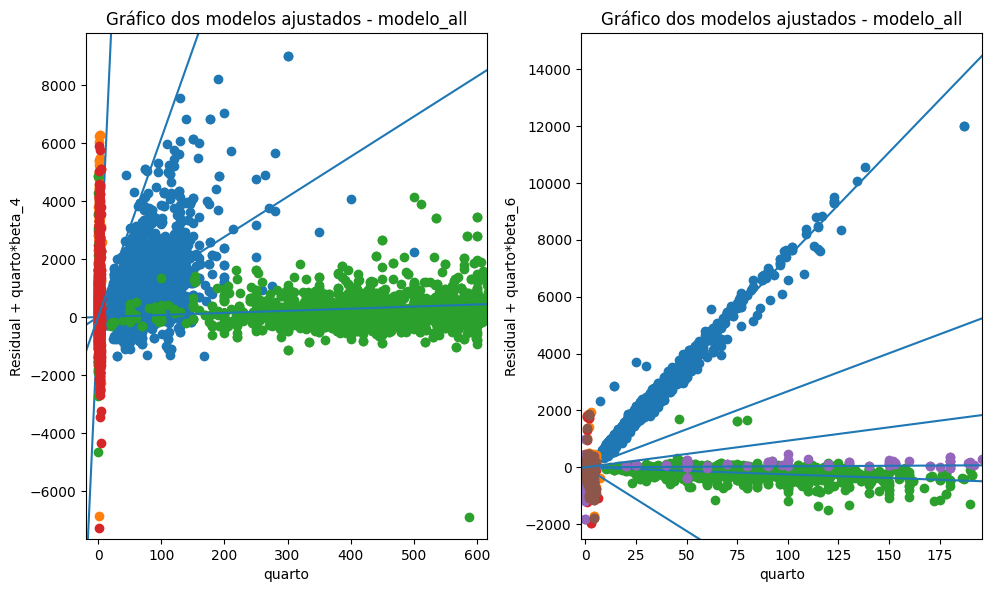

In [21]:
num_modelos = len(modelos)
fig, axes = plt.subplots(1, num_modelos, figsize=(5 * num_modelos, 6))

for ax, (nome, modelo, col) in zip(axes, modelos):
    if isinstance(col, pd.Series):
        sm.graphics.plot_ccpr(modelo, col.name, ax=ax)
        ax.set_title(f"Gráfico dos modelos ajustados - {nome}")
    else:
        for i in col.columns:
            sm.graphics.plot_ccpr(modelo, i, ax=ax)
        ax.set_title(f"Gráfico dos modelos ajustados - modelo_all")
plt.tight_layout(pad=1.0)
plt.show()

# 8. Conclusão

ESCREVER CONCLUSÃO